# Departure by plane model


## Importing
Importing libraries. Setting `%matplotlib inline` to plott the graph inside the notebook

In [1]:
%matplotlib inline

import pandas as pd
import geopandas
from shapely.geometry import Point, Polygon
import fiona
import datetime
import numpy as np

Importing CSV

In [33]:
# Import Points
#df_points = pd.read_csv('data/20180521_sampled.csv')
df_points = pd.read_csv('../data_generated/20180521.csv')

In [67]:
#Import Plane list
df_planes = pd.read_csv('../data_generated/swiss_airplanes.csv')

## Join points and airplanes

In [68]:
# set index
df_planes = df_planes.set_index('icao24')

# Join
df_joined = df_points.join(df_planes, on='icao24')

In [69]:
# Only take swiss planes
df_swiss = df_joined[df_joined.status == 'active']

#Cleanup
df_swiss['timestamp'] = pd.to_datetime(df_swiss['timestamp'], format='%Y-%m-%d %H:%M:%S')
df_swiss['run'] = None
df_swiss = df_swiss.round({'altitude': 0})

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


**Fehler vorhanden.** Manche Starts kommen doppelt

In [83]:
#TMP
df_swiss = df_swiss[df_swiss['icao24'].isin(["4b1881", "4b1801"])]

# Set Multiindex
indexed = df_swiss.set_index(['icao24', 'timestamp'])

#Cleanup
#indexed = indexed[(indexed['altitude'] > 0) & (indexed['altitude'] < 1605)]


#create empty dataset
df_departures = pd.DataFrame(data=None, columns=indexed.columns)

# Loop all icao24 (index)
for icao24 in indexed.index.get_level_values('icao24').unique():
    
    print(icao24)
    
    # Get all Points from plane
    df_current_plane = df_swiss[df_swiss['icao24'] == icao24]
    
    df_current_plane = df_current_plane[df_current_plane['altitude'] > 0]
    df_current_plane = df_current_plane[df_current_plane['altitude'] < 1605]
    
    df_current_plane['vertical_rate_prev'] = df_current_plane['vertical_rate'].shift(1)
    df_current_plane['startpoint'] = np.where((df_current_plane['vertical_rate_prev'] <= 0) & (df_current_plane['vertical_rate'] > 0), True, False)
    
    df_startsPerPlane = df_current_plane[df_current_plane['startpoint'] == 1]
    
    print("== " + str(len(df_startsPerPlane)) + " ==")

    c = 0
    for i, startpoint in df_startsPerPlane.iterrows():
        starttime = df_startsPerPlane.at[i, 'timestamp']
        endtime = starttime + datetime.timedelta(minutes=1)
        print(str(starttime) +' - ' + str(endtime))
        track = df_swiss[(df_swiss['timestamp'] >= starttime) & (df_swiss['timestamp'] < endtime)]
        print(len(track))
        track['timesincedeparture'] = track['timestamp'] - starttime
        track['timesincedeparture_int'] = track['timesincedeparture'].dt.total_seconds()
        track['run'] = c
        df_departures = pd.concat([df_departures, track])
        c += 1

    #print(len(df))
    #print(icao24)
    #print(indexed.loc[date])
    
print(len(df_departures))

4b1801
== 3 ==
2018-05-21 17:55:03 - 2018-05-21 17:56:03
60


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

2018-05-21 23:02:35 - 2018-05-21 23:03:35
60
2018-05-21 23:02:38 - 2018-05-21 23:03:38
60
4b1881
== 1 ==
2018-05-21 10:09:41 - 2018-05-21 10:10:41
60
240


In [84]:
# Export departures



#Timestamp to string
export = df_departures.copy()
export['timestamp'] = export['timestamp'].astype(str)

#Drop bools and others
export = export.drop(['alert', 'spi', 'timesincedeparture'], axis=1)

# Create Geometry
geometry = [Point(xy) for xy in zip(export.longitude, export.latitude)]
geo_df = geopandas.GeoDataFrame(export, crs={'init': 'epsg:4326'}, geometry=geometry)

#export
geo_df.to_file("../qgis/departures.shp")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
CPLE_NotSupported in Normalized/laundered field name: 'Registration' to 'Registrati'
CPLE_NotSupported in Normalized/laundered field name: 'baro_altitude' to 'baro_altit'
CPLE_NotSupported in Normalized/laundered field name: 'ground_speed' to 'ground_spe'
CPLE_NotSupported in Normalized/laundered field name: 'last_position' to 'last_posit'
CPLE_NotSupported in Normalized/laundered field name: 'timesincedeparture_int' to 'timesinced'
CPLE_NotSupported in Normalized/laundered field name: 'vertical_rate' to 'vertical_r'


In [51]:
# Turn axis
pivot = df_departures.pivot('timesincedeparture', columns='icao24', values='altitude')

pivot.head()
#pivot.plot(kind='line')




ValueError: Index contains duplicate entries, cannot reshape

## Looking at last vertical_rate

In [29]:
#Test Peakdetection
import numpy as np

#4b1881
#4b1801
#4b17fd

df_swiss = df_joined[df_joined.status == 'active']
df_swiss = df_swiss[df_swiss['icao24'] == '4b169a']

df_swiss = df_swiss.round({'altitude': 0})

df_swiss = df_swiss.reset_index(drop=True)

df_swiss['timestamp'] = pd.to_datetime(df_swiss['timestamp'], format='%Y-%m-%d %H:%M:%S')

df_swiss_cleaned = df_swiss.copy()

#Remove leerwerte
df_swiss_cleaned = df_swiss_cleaned[df_swiss_cleaned['altitude'] > 0]
df_swiss_cleaned = df_swiss_cleaned[df_swiss_cleaned['altitude'] < 1605]

df_swiss_cleaned['vertical_rate_prev'] = df_swiss_cleaned['vertical_rate'].shift(1)
df_swiss_cleaned['startpoint'] = np.where((df_swiss_cleaned['vertical_rate_prev'] <= 0) & (df_swiss_cleaned['vertical_rate'] > 0), True, False)

startpoints = df_swiss_cleaned[df_swiss_cleaned['startpoint'] == True]


#df_swiss['onground'] = df_swiss['onground'].astype(int)

#arr = df_swiss['altitude'].values
##df_swiss.to_csv("test.csv", sep=';')

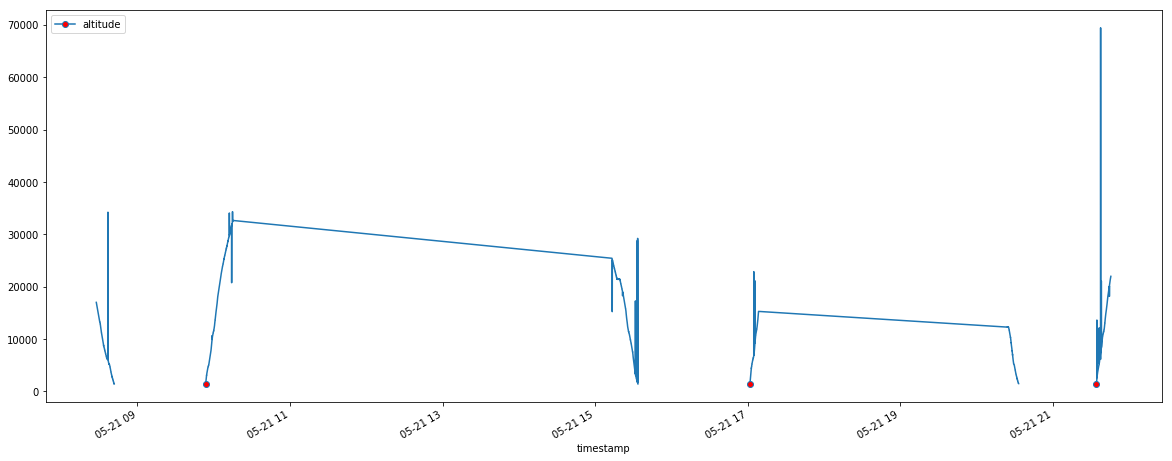

In [30]:
markers_on = list(startpoints.index.values)
df_swiss.plot(x='timestamp', y='altitude', figsize=(20,8), markevery=markers_on, marker='o', markerfacecolor='r')

## End approach

## Peakdetection approach
https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
http://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
Go by finding valleys.

Probleme: Findet ersten start nicht.

In [9]:
#Test Peakdetection
from detect_peaks import detect_peaks
#4b1881
#4b1801

df_swiss = df_joined[df_joined.status == 'active']

df_swiss = df_swiss[df_swiss['icao24'] == '4b17fd']


df_swiss = df_swiss.round({'altitude': 0})
df_swiss['timestamp'] = pd.to_datetime(df_swiss['timestamp'], format='%Y-%m-%d %H:%M:%S')
#df_swiss = df_swiss[df_swiss['ground_speed'] > 0]
#df_swiss = df_swiss[df_swiss['onground'] != 1]

#Remove leerwerte
df_swiss = df_swiss[df_swiss['altitude'] > 0]

# Alle ausreisser weg
#df_swiss = df_swiss[df_swiss['altitude'] < 3000]

#df_swiss = df_swiss[df_swiss['altitude'] > 1575]
#df_swiss['onground'] = df_swiss['onground'].astype(int)

arr = df_swiss['altitude'].values
#df_swiss.to_csv("test.csv", sep=';')

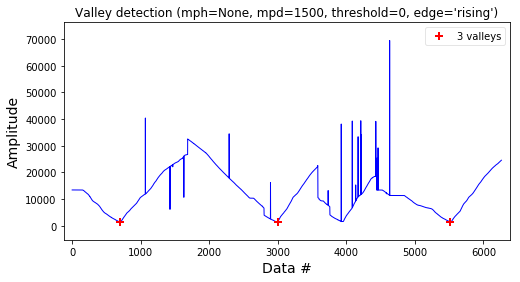

array([ 701, 2999, 5514])

In [10]:
#cb = np.array(arr)
x = arr
#indexes = peakutils.indexes(cb, thres=500, min_dist=10)
#indexes
r = detect_peaks(x, mpd=1500, valley=True, show=True)
r


## Not working approach

In [80]:
#TMP
#df_swiss = df_swiss[(df_swiss['icao24'] == '4b1881') | (df_swiss['icao24'] == '4b1801')]
df_swiss = df_swiss[df_swiss['icao24'] == '4b1881']


# Round altitude
df_swiss = df_swiss.round({'altitude': 0})

# Timestamp to DateTime
df_swiss['timestamp'] = pd.to_datetime(df_swiss['timestamp'], format='%Y-%m-%d %H:%M:%S')

# Cleanup dataset
df_swiss = df_swiss[df_swiss['ground_speed'] > 0]
df_swiss = df_swiss[df_swiss['onground'] != 1]
df_swiss = df_swiss[df_swiss['altitude'] > 1575]
df_swiss['onground'] = df_swiss['onground'].astype(int)
#df_swiss = df_swiss[df_swiss['vertical_rate'] >= 0]

#df_swiss = df_swiss[df_swiss['altitude'] > 0]

In [81]:
def isFirstPoint(row):
    # timestamp_prev is empty means, its the first point in the dataset and a startpoint
    if pd.isna(row['timestamp_prev']) and row['altitude'] < 2000:
      return 1
    
    if ( row['timestamp'] > row['timestamp_prev'] + datetime.timedelta(seconds=20)) and row['altitude'] < 2000:
       return 1
    else:
       return 0

# Ramsch

In [31]:
#df_swiss = df_joined[df_joined.status == 'active']
#df_swiss.sample()

In [75]:
# Create Geometry
geometry = [Point(xy) for xy in zip(df_departures.longitude, df_departures.latitude)]
geo_df = geopandas.GeoDataFrame(df_departures, crs={'init': 'epsg:4326'}, geometry=geometry)

In [76]:
#df_departers.to_csv('test.csv')

#Timestamp to string
geo_df['timestamp'] = geo_df['timestamp'].astype(str)

#Drop bools and others
geo_df = geo_df.drop(['alert', 'spi', 'timestamp_prev', 'timesincedeparture'], axis=1)

geo_df.to_file("qgis/test.shp")

In [381]:


ALT


# This script looks for the starting point. One plane could have more than one starting point at a day
"""
def isFirstPoint(row):
    # timestamp_prev is empty means, its the first point in the dataset and a startpoint
    if pd.isna(row['timestamp_prev']):
      return 1
    
    if ( row['timestamp'] > row['timestamp_prev'] + datetime.timedelta(seconds=20)) and row['altitude'] < 2000:
       return 1
    else:
       return 0


icao24['timestamp_prev'] = icao24['timestamp'].shift(1)
icao24['startpoint'] = icao24.apply(isFirstPoint, axis=1)
icao24[icao24['startpoint'] == 1]
"""

# Make it easier. Just take the first starting point. Forget all the other departures of this plane
icao24 = icao24.reset_index(drop=True)

starttime = icao24.at[0, 'timestamp']
track = icao24[icao24['timestamp'] < starttime + datetime.timedelta(minutes=1)]
track['timesincedeparture'] = track['timestamp'] - starttime
track['timesincedeparture_int'] = track['timesincedeparture'].dt.total_seconds()

#track = track.set_index('icao24')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [283]:
icao24 = geo_df[geo_df['icao24'] == '4b1801']
#icao24.plot()

In [426]:
# Turn axis
pivot = track.pivot('timesincedeparture', columns='icao24', values='altitude')

pivot.head()
#pivot.plot(kind='line')




icao24,4b1801
timesincedeparture,
00:00:00,1600.0
00:00:01,1625.0
00:00:02,1625.0
00:00:03,1700.0
00:00:04,1750.0


In [288]:
#Timestamp to string
track['timestamp'] = track['timestamp'].astype(str)

#Drop bools and others
track = track.drop(['alert', 'spi'], axis=1)

#export
track.to_file("qgis/4b1801_short.shp")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


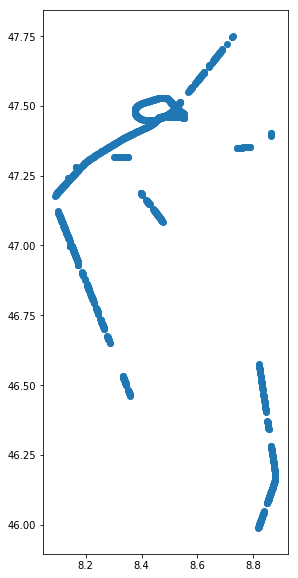

In [136]:
icao24.plot(figsize=(10,10))

In [ ]:
# Airport Zurich
coords = [( 47.4863, 8.4994 ), ( 47.4283, 8.4994 ), ( 47.4283, 8.619 ), ( 47.4863, 8.619 ), ( 47.4863, 8.4994 )]
zurich_airport = Polygon(coords)

In [ ]:
df_zurich = geo_df[geo_df.geometry.within(zurich_airport)]

In [ ]:
df_zurich.plot(figsize=(12, 12),markersize=1, alpha=0.4)